In [1]:
using PyPlot, LinearAlgebra, Interact

WebIO._IJuliaInit()

# Stochastic optimization

Many practical optimization problems in machine learning, or other fields involving "fitting to data", have the property that their objective ("loss") functions are **additive**, i.e. you are minimizing an **average**:
$$
f(x) = \frac{1}{m} \sum_{i=1}^m f_i(x) \longrightarrow_{m \to \infty} E[f_i(x)]\, .
$$
where the different functions $f_i(x)$ correspond to **samples** from a **training set** of $m \gg 1$ data points.   In the limit $m \to \infty$, this corresponds to minimizing the **expected value**.  (For example, if training examples are drawn randomly from some distribution (for [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning)), you effectively have an infinite training set.)

The most familiar example is probably **least-square fitting**, $f_i(x)$ is the squared difference between a model and a training data point $(\text{input}_i, \text{output}_i)$:
$$
f_i(x) = \left\Vert \text{model}(x, \text{input}_i) - \text{output}_i \right\Vert_2^2 \, .
$$
As another example, in [maximum-likelihood estimation](https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/08/19/01-Maximum-likelihood-estimation.html) one maximizes a "likelihood" probability, which can equivalently be formulated as minimizing the negative **log-likelihood** of the form:
$$
f_i(x) = -\log L(\text{output}_i | \text{model}(x, \text{input}_i))
$$
(where $L$ is a likelihood function in some statistical model, e.g. corresponding to [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) in [classification problems](https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451)).  There are many other examples of this $f = \sum_i f_i$ form.

Gradient descent and related algorithms update the parameters $x$ using the gradient $\nabla f$ evaluated at the current point (or possibly a linear combination of gradients at different points), but evaluating the gradient exactly might be very expensive if $m$ is large.  However, by linearity, what we are computing is
$$
\nabla f = \frac{1}{m} \sum_{i=1}^m \nabla f_i \longrightarrow_{m \to \infty} \boxed{ E[\nabla f_i] }\, ..
$$
which is effectively the **expected value of the gradient** on all the samples.

In **stochastic optimization algorithms**, instead of computing the *exact* gradient $\nabla f$, we instead **estimate the gradient** by **random sampling** of only a few points — maybe even just one! — and use this to update $x$.   A type of [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method), this leads to a dramatic gain of comptuational efficiency, at the price of more **variance** in the convergence.

In this notebook, we demonstrate a couple of basic algorithms for stochastic optimization on a simple linear-regression problem.

## A simple least-squares fitting problem

Let's fit $m$ data points $(a_i, b_i)$ to a straight line $a(b) = x_1 + x_2 b$.  With a least-square fit, minimizing
$$f(x) = \Vert b - Ax \Vert^2/m =\frac{1}{m} \sum_i \underbrace{(b_i - (Ax)_i)^2}_{f_i(x)}\, ,$$
the solution is simply $\hat{x} = A \setminus b = (A^T A)^{-1} A^T b$ where

$$
A = \begin{pmatrix} 1 & a_1 \\ 1 & a_2 \\ \vdots & \vdots \\ 1 & a_m \end{pmatrix}
$$

Let's do that for 1000 data points given by a line $1 + 2a$ plus some noise:

In [2]:
m = 1000
a = randn(m)
b = @. 1 + 2a + randn()
A = [one.(a) a]
x̂ = A \ b

2-element Vector{Float64}:
 1.0153932906611167
 2.0330023666722448

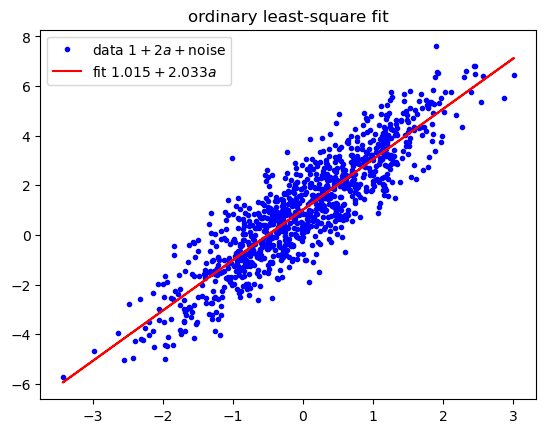

PyObject <matplotlib.legend.Legend object at 0x15996a370>

In [3]:
title("ordinary least-square fit")
plot(a, b, "b.")
plot(a, x̂[1] .+ x̂[2] .* a, "r-")
legend([L"data $1+2a+\mathrm{noise}$", L"fit $%$(round(x̂[1],digits=3)) + %$(round(x̂[2],digits=3))a$"])

## Gradient descent

We can instead solve this problem by gradient descent with a fixed learning rate $s$.  At each iteration
$$
x^{(k+1)} = x^{(k)} - s \nabla f^{(k)}
$$
where for $f(x) = \frac{1}{m}\Vert b - Ax \Vert^2 = \frac{1}{m}(b-Ax)^T (b-Ax)$ we have $\nabla f = \frac{2}{m}A^T(Ax - b)$.   We'll start with an initial "guess" of $x^{(1)} = [0,0]$.

This is sometimes called **"full batch" gradient descent"**: we are looking at the **whole "batch"** of training data at once.

We'll use the [Interact.jl package](https://github.com/JuliaGizmos/Interact.jl) to visualize the progress of this algorithm as we vary the "learning rate" $s$.

For goodd convergence, we should typically have $s < 1/L$ where $L \approx 2$ is the Lipschitz constant of $f$, corresponding to the largest eigenvalue of the Hessian $2A^T A / m$.  So, for convenience we'll specify $sL$ instead of $s$.

For $s > 1/L$ it "overshoots" the optimum and starts to oscillate, but it still converges if it overshoots by less than a factor of 2 (so each step still ends up closer to the optimum).  If $s > 2/L$ then it overshoots by more than a factor of 2 (each step ends up *farther* from the optimum) and iterations diverge.

In [4]:
f(x) = norm(b-A*x)^2 / m
f(x1,x2) = f([x1,x2])
x1 = range(-2,3, length=100)
x2 = range(0,4,length=100)
fvals = f.(x1',x2)

@show L = (2/m) * maximum(eigvals(A'*A)) # Lipschitz constant

f1 = figure(figsize=(10,4))
@manipulate for sL in slider(0.05:0.05:2.1, value=0.3, label="s × L"),
                iterations in slider(10:100, value=20, label="# iterations")
    withfig(f1) do
        s = sL / L
        x = [0.0,0.0]
        X = [x]
        ΔX = [norm(x - x̂)]
        for i = 1:iterations
            ∇f = (2/m)*(A'*(A*x - b))
            x = x - s * ∇f
            push!(X, x)
            push!(ΔX, norm(x - x̂))
        end
        
        subplot(1,2,1)
        plt.subplots_adjust(wspace=0.4)
        contour(x1', x2, fvals)
        plot(x̂[1], x̂[2], "r*")
        plot(getindex.(X,1), getindex.(X,2), "ko-")
        xlabel(L"x_1")
        ylabel(L"x_2")
        title("gradient-descent iterates x")
        
        subplot(1,2,2)
        semilogy(ΔX, "ko-")
        ylim(1e-10, 100)
        xlabel("iteration")
        ylabel(L"\Vert x - \hat{x} \Vert")
        title("|error| in x")
    end
end

L = (2 / m) * maximum(eigvals(A' * A)) = 2.0048257127550775


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["s × L"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 42, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(6), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/stevenj/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/stevenj/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/stevenj/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/Users/stevenj/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/Users/stevenj/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001107afb00, Task (runnable) @0x00000001107afb00), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.05\",\"0.1\",\"0.15\",\"0.2\",\"0.25\",\"0.3\",\"0.35\",\"0.4\",\"0.45\",\"0.5\",\"0.55\",\"0.6\",\"0.65\",\"0.7\",\"0.75\",\"0.8\",\"0.85\",\"0.9\",\"0.95\",\"1.0\",\"1.05\",\"1.1\",\"1.15\",\"1.2\",\"1.25\",\"1.3\",\"1.35\",\"1.4\",\"1.45\",\"1.5\",\"1.55\",\"1.6\",\"1.65\",\"1.7\",\"1.75\",\"1.8\",\"1.85\",\"1.9\",\"1.95\"

## Stochastic gradient descent

In the most basic form of stochastic gradient descent, we look at one data point at a time, chosen at random.  More generally, we can look at "mini-batches" of $M$ data points at a time.  That is, we will only **estimate**
$$
\nabla f = E[\nabla f_i] \approx \frac{1}{M} \sum_{i \in \text{mini-batch}} \nabla f_i
$$
The simplest case is $M=1$: we only look at one data point at a time!

This is *much* cheaper than computing $\nabla f$ when the size of the training is large.   (In fact, we can even handle *infinite* training sets this way, where the training data is generated randomly as needed.)

Let's see how it works for the problem above, sampling data at random from an infinite ($m=\infty$) training set generated as needed from the same model as above, again using the simplest possible algorithm with a fixed step size:

In [5]:
x̂₀ = [1,2] # ground-truth model

f2 = figure(figsize=(10,4))
@manipulate for sL in slider(0.01:0.01:0.4, value=0.2, label="s × L"),
                M in slider(1:100, value=1, label="mini-batch M"),
                iterations in slider(10:100, value=50, label="# iterations")
    withfig(f2) do
        s = sL / L
        x = [0.0,0.0]
        X = [x]
        ΔX = [norm(x - x̂₀)]
        for i = 1:iterations
            # generate a mini-batch of size M:
            ã = randn(M)
            b̃ = @. 1 + 2ã + randn()
            Ã = [one.(ã) ã]
            
            # approximate gradient from this mini-batch
            ∇f̃ = (2/M)*(Ã'*(Ã*x - b̃))
            x = x - s * ∇f̃
            push!(X, x)
            push!(ΔX, norm(x - x̂₀))
        end
        
        subplot(1,2,1)
        plt.subplots_adjust(wspace=0.4)
        contour(x1', x2, fvals)
        plot(x̂₀[1], x̂₀[2], "r*")
        plot(getindex.(X,1), getindex.(X,2), "ko-")
        xlabel(L"x_1")
        ylabel(L"x_2")
        title("gradient-descent iterates x")
        
        subplot(1,2,2)
        semilogy(ΔX, "ko-")
        ylim(1e-2, 2)
        xlabel("iteration")
        ylabel(L"\Vert x - \hat{x} \Vert")
        title("|error| in x")
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["s × L"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 40, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(20), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/stevenj/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/stevenj/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/stevenj/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/Users/stevenj/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/Users/stevenj/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001107ae570, Task (runnable) @0x00000001107ae570), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.01\",\"0.02\",\"0.03\",\"0.04\",\"0.05\",\"0.06\",\"0.07\",\"0.08\",\"0.09\",\"0.1\",\"0.11\",\"0.12\",\"0.13\",\"0.14\",\"0.15\",\"0.16\",\"0.17\",\"0.18\",\"0.19\",\"0.2\",\"0.21\",\"0.22\",\"0.23\",\"0.24\",\"0.25\",\"0.26\",\"0.27\",\"0.28\",\"0.29\",\"0.3\",\"0.31\",\"0.32\",\"0.33\",\"0.34\",\"0.35\",\"0.36\",\"0.37\",

Some things to note:

* Far from the solution, SGD converges quickly, but then starts to "bounce around" the minimum.
* The process **converges "on average"**: $E[x^{(k)}]$ (the average after repeating SGD many times) is equivalent to the k-th step of exact/full-batch gradient descent.  The difference is that now we have **variance**.  (But the variance is not necessarily a bad thing, as discussed below, because it can suppress over-fitting!)

One thing to notice is that increasing the mini-batch size $M$ has a very similar qualitative effect to decreasing the learning rate $s$.   The intuitive reason for this is that taking $M$ tiny steps with a single sample each (which hardly changes $x$, so the gradients of the different samples are *almost* at the same $x$) is effectively almost the same as taking a single larger step with $M$ samples (evaluated at the same $x$).

Let's try this for 2000 iterations with $M=1$ and $s = 0.2/L$ vs. 100 iterations with $M=20$ and $s=0.2/20L = 0.01/L$.  (Notice that the total number of samples is the same in both cases!  In the former case we will only plot every 20th step so that the graphs are comparable.)

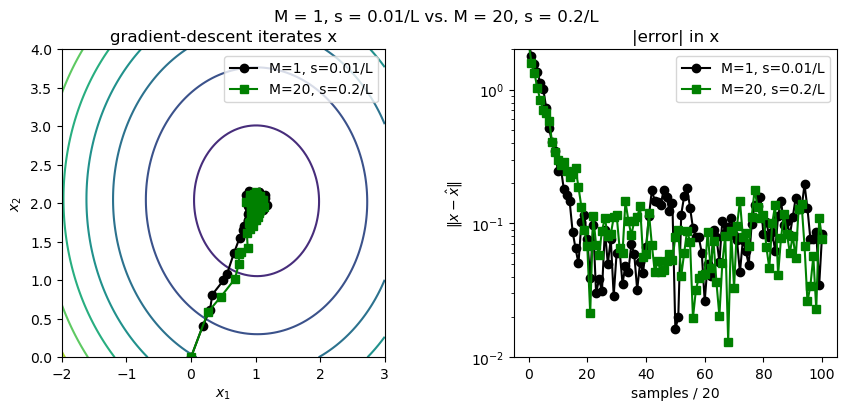

PyObject Text(0.5, 1.0, '|error| in x')

In [6]:
sL = 0.2/20
M = 1
iterations = 20*100
s = sL / L
x = [0.0,0.0]
X1 = [x]
ΔX1 = [norm(x - x̂₀)]
for i = 1:iterations
    # generate a mini-batch of size M:
    ã = randn(M)
    b̃ = @. 1 + 2ã + randn()
    Ã = [one.(ã) ã]

    # approximate gradient from this mini-batch
    ∇f̃ = (2/M)*(Ã'*(Ã*x - b̃))
    x = x - s * ∇f̃
    if i % 20 == 0
        push!(X1, x)
        push!(ΔX1, norm(x - x̂₀))
    end
end


sL = 0.2
M = 20
iterations = 100
s = sL / L
x = [0.0,0.0]
X20 = [x]
ΔX20 = [norm(x - x̂₀)]
for i = 1:iterations
    # generate a mini-batch of size M:
    ã = randn(M)
    b̃ = @. 1 + 2ã + randn()
    Ã = [one.(ã) ã]

    # approximate gradient from this mini-batch
    ∇f̃ = (2/M)*(Ã'*(Ã*x - b̃))
    x = x - s * ∇f̃
    push!(X20, x)
    push!(ΔX20, norm(x - x̂₀))
end


figure(figsize=(10,4))
suptitle("M = 1, s = 0.01/L vs. M = 20, s = 0.2/L")

subplot(1,2,1)
plt.subplots_adjust(wspace=0.4)
contour(x1', x2, fvals)
plot(getindex.(X1,1), getindex.(X1,2), "ko-")
plot(getindex.(X20,1), getindex.(X20,2), "gs-")
legend(["M=1, s=0.01/L", "M=20, s=0.2/L"])
xlabel(L"x_1")
ylabel(L"x_2")
title("gradient-descent iterates x")

subplot(1,2,2)
semilogy(ΔX1, "ko-")
semilogy(ΔX20, "gs-")
legend(["M=1, s=0.01/L", "M=20, s=0.2/L"])
ylim(1e-2, 2)
xlabel("samples / 20")
ylabel(L"\Vert x - \hat{x} \Vert")
title("|error| in x")

**Why use mini-batches at all, then?**  Why not always use $M=1$ and just shrink $s$ as needed?

The answer is simple: **parallel computing**.   The big advantage of a mini-batch is that then you can evaluate $\nabla f_i$ **in parallel** for each sample in the mini-batch, e.g. using a multi-core computer, GPUs, or distributed-memory clusters.

At first glance, it may seem that we would want to increase $M$ as much as possible, within the limits of our compute power, since the "ideal" is surely to optimize over the whole training set at once, right?   Actually, no!   The danger of increasing $M$ by too much (or equivalently, making $s$ too small), is that it can easily lead to **over-fitting**.   The fact that stochastic optimization with small batches tends to "bounce around" the nominal optimum can be a benefit rather than a problem in machine-learning problems, because it tends to prevent you from over-fitting to the training data and failing to **generalize** well to other test data.

* *In this simple linear-regression example, there are only 2 parameters x, so we are not in much danger of overfitting.  This is more of a concern with huge models like neural networks that have an enormous number of parameters.*

There are many variations and refinements of mini-batching for stochastic gradient descent that are being explored in the machine-learning literature, and many open problems.  For example:

* If you have a set of $m$ training data points, the statistical theory of mini-batching is clearest if you draw samples from this set *independently*, which means that you might occasionally draw the same sample more than once (i.e. you are "sampling with replacement").  However, for performance reasons nearly all machine learning is done by randomly shuffling the test data once and then streaming through it *in order* (*sequential* access = fast!), corresponding to "sampling without replacement".  Unfortunately, it's *much* harder to prove theoretical guarantees for without-replacement sampling; for recent progress, see e.g. [Shamir (2016)](https://arxiv.org/abs/1603.00570).
* Not all training data is created equal!   Some data points, e.g. more "unusual" data points, might contribute more to $\nabla f$ and hence be more "informative" about how to update the parameters $x$.   This leads to algorithms that try to sample training data non-uniformly, such as **importance sampling** (e.g. [Csiba and Richtárik (2016)](https://arxiv.org/abs/1602.02283)) and **active learning** (e.g. [Chakraborty et al. (2015)](https://doi.org/10.1109/TPAMI.2015.2389848) or [Lakshiminarayanan et al (2016)](https://arxiv.org/abs/1612.01474)).
* Various strategies have been explored to compensate for the generalization problem of large batch sizes.  See e.g. [Keskar et al. (2016)](https://arxiv.org/abs/1609.04836) or [Hoffer et al. (2017)](https://arxiv.org/abs/1705.08741).  Of course, one alternative is to parallelize *within each* $f_i$ rather than over different samples, e.g. as described in [Huang et al. (2018)](https://arxiv.org/abs/1811.06965).
* In training a neural network that has multiple "layers" (i.e. $f_i$ is a composition of several functions), it is common to use the mini-batch in order to insert additional rescaling transformations into each layer, an algorithm known as [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization).

## The Adam algorithm for stochastic optimization

A popular algorithm for stochastic optimization is [Adam (Kingma & Ba, 2015)](https://arxiv.org/pdf/1412.6980.pdf), which adds several features:

* It has a "momentum" or "memory" term, where the gradient is estimated by a *weighted average* of the current mini-batch gradient and the previous gradient estimate.
* It also estimates the *variance* of the gradient components in the same way, and essentially uses this as rough diagonal estimate of the Hessian: it takes a "crude Newton"-like step where the gradient components are weighed inversely by the square roots of their variances.

It's quite simple to implement directly from the description in the paper linked above.  Let's try it!

In [7]:
x̂₀ = [1,2] # ground-truth model

# typical Adam hyper-parameters
ϵ = 1e-8
β₁ = 0.9
β₂ = 0.999

f2 = figure(figsize=(10,4))
@manipulate for log₁₀α in slider(-4:0.2:0, value=-1, label="learning rate log₁₀α"),
                M in slider(1:100, value=1, label="mini-batch M"),
                iterations in slider(10:10:300, value=300, label="# iterations")
    withfig(f2) do
        α = exp10(log₁₀α)
        x = [0.0,0.0]
        X = [x]
        ΔX = [norm(x - x̂₀)]
        mom = zero(x) # initial 1st-moment (mean gradient)
        var = zero(x) # initial 2nd-moment (mean gradient.^2)
        for t = 1:iterations
            # generate a mini-batch of size M:
            ã = randn(M)
            b̃ = @. 1 + 2ã + randn()
            Ã = [one.(ã) ã]
            
            # approximate gradient from this mini-batch
            ∇f̃ = (2/M)*(Ã'*(Ã*x - b̃))
            
            # Adam update
            mom = β₁*mom + (1-β₁)*∇f̃
            var = β₂*var + (1-β₂)*(∇f̃.^2)
            m̂ = mom / (1 - β₁^t) # normalize by total weights
            v̂ = var / (1 - β₂^t) # normalize by total weights
            x = @. x - α * m̂ / (√v̂ + ϵ)
            
            push!(X, x)
            push!(ΔX, norm(x - x̂₀))
        end
        
        subplot(1,2,1)
        plt.subplots_adjust(wspace=0.4)
        contour(x1', x2, fvals)
        plot(x̂₀[1], x̂₀[2], "r*")
        plot(getindex.(X,1), getindex.(X,2), "ko-")
        xlabel(L"x_1")
        ylabel(L"x_2")
        title("gradient-descent iterates x")
        
        subplot(1,2,2)
        semilogy(ΔX, "ko-")
        ylim(1e-2, 2)
        xlabel("iteration")
        ylabel(L"\Vert x - \hat{x} \Vert")
        title("|error| in x")
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["learning rate log₁₀α"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 21, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(16), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/stevenj/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/stevenj/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/stevenj/.julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), Asset("css", nothing, "/Users/stevenj/.julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), Asset("css", nothing, "/Users/stevenj/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013960e9c0, Task (runnable) @0x000000013960e9c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-4.0\",\"-3.8\",\"-3.6\",\"-3.4\",\"-3.2\",\"-3.0\",\"-2.8\",\"-2.6\",\"-2.4\",\"-2.2\",\"-2.0\",\"-1.8\",\"-1.6\",\"-1.4\",\"-1.2\",\"-1.0\",\"-0.8\",\"-0.6\",\"-0.4\",\"-0.2\",\"0.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"3943181141435372841\",\"id\":\"3223888397370739056\",\"type\":\"obs

With correctly tuned hyperparameters, Adam converges a bit more smoothly — with *less variance* — than naive stochastic gradient descent, even for a mini-batch size $M=1$.   The "memory" effect of averaging the gradient over many iterations helps with this!

I should also point out that this is a **very well-conditioned test problem** as evidenced by the nearly circular contours of $f(x)$ as seen in these examples.    In such cases naive gradient descent often works very well, and there is not as much benefit from either momentum terms or weighting the gradient inversely with the variance.   Many realistic learning problems are badly conditioned, however, and these enhancements of Adam (and related algorithms) may make a much bigger difference!

In [8]:
cond(A'A) # condition number of the Hessian

1.0272553557565167

(See, well-conditioned!)

## Other algorithms and generalizations

There are *many, many* other stochastic optimization algorithms, some of which are linked in the Wikipedia article on [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), with many variants on ways to choose parameters like learning rates and momentum coefficients.  This includes many algorithms similar in spirit to Adam and accelerated gradient descent, such as the [YOGI algorithm (Zaheer et al., 2018)](https://papers.nips.cc/paper_files/paper/2018/hash/90365351ccc7437a1309dc64e4db32a3-Abstract.html) which has better convergence guarantees than Adam; fancier quasi-Newton algorithms (see e.g. [Zhao et al. (2017)](https://arxiv.org/abs/1704.00116) and references therein); and also algorithms for more complicated optimization problems than simply minimizing $f(x)$: stochastic optimization with nonlinear constraints (see e.g. [Lan and Zhou (2016)](https://arxiv.org/abs/1604.03887), stochastic "minimax" problems (e.g. [Yang et al. (2022)](https://arxiv.org/abs/2202.07868)), and robust stochastic optimization (e.g. [Chen et al (2020)](https://doi.org/10.1287/mnsc.2020.3603)).

Note that all of these algorithms can be trivially modified to accommodate objective functions that have a non-stochastic part, e.g.:
$$
f(x) = f_0(x) + E[f_i(x)] \, ,
$$
since then $\nabla f = \nabla f_0 + E[\nabla f_i]$ and you can estimate $\nabla f$ by computing $\nabla f_0$ *exactly* and then estimating $E[\nabla f_i]$ from a mini-batch sample.   For example, this arises in [Tikhonov-regularized least-squares](https://en.wikipedia.org/wiki/Ridge_regression):
$$
f(x) = \underbrace{\lambda \Vert x \Vert_2^2}_{f_0(x)} + \frac{1}{m} \sum_i \underbrace{\left\Vert \text{model}(x, \text{input}_i) - \text{output}_i \right\Vert_2^2}_{f_i(x)}\, ,
$$
where $\nabla f_0 = 2\lambda x$ is easy and cheap to compute since it is independent of $m$.